In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_vector
from sympy.physics.matrices import msigma
from sympy.physics.quantum.dagger import Dagger
from sympy import Matrix
from sympy import I, N, re, exp, sin, cos, pi, eye
import numpy as np

In [26]:
def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    ϕ = np.arctan2(y, x) #az
    θ = np.arctan2(hxy, z) #el
    return [r, ϕ, θ]

def to_cartesian(polar):
    r = polar[0]
    ϕ = polar[1]
    θ = polar[2]

    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]

In [27]:
def rn_su2_euler(vec, rx, ry, rz, plot=False):
    stabilized_vec = np.array(vec)+0.000001
    spherical_vec = to_spherical(stabilized_vec)
    ϕ = spherical_vec[1]
    θ = spherical_vec[2]
    if plot: print(f'Initial vector: \t{vec}.')
    if plot: print(f'Spherical coords: \t{spherical_vec}.')

    # https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)
    
    sx = msigma(1)
    sy = msigma(2)
    sz = msigma(3)
    M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
    
    if plot: print(f'#{i}: M_q={M_q}')
    r_hat = np.array([rx, ry, rz])
    r = np.sqrt(float(np.tensordot(r_hat, r_hat, axes=1)))

    if plot: print(f'Rotation angle = {r}')
    n_hat = r_hat/(r)
    sigma_hat = np.array([sx, sy, sz])
    n_sigma_product = Matrix(np.tensordot(n_hat,sigma_hat, axes=1))


    U_n = N(exp(-1j*n_sigma_product*r/2))
    #U_n_syntetic = [[np.cos(r/2), -1j*np.sin(r/2)],[-1j*np.sin(r/2), np.cos(r/2)]]

    
    M_q_rotated = N(U_n*M_q*Dagger(U_n))
    # Source: https://en.wikipedia.org/wiki/Pauli_matrices#Pauli_vector

    q_1 = re((M_q_rotated[0,1]+M_q_rotated[1,0])/2)
    q_2 = re((M_q_rotated[1,0]-M_q_rotated[0,1])/2j)
    q_3 = re(M_q_rotated[0,0])
    q_rotated = [np.real(N(q_1)), np.real(N(q_2)), np.real(N(q_3))]
    return q_rotated

In [28]:
def extract_angles(M_q_rotated):
    cos_θ_rotated = float(N(re(M_q_rotated[0,0])))
    θ_rotated = np.arccos(cos_θ_rotated)
    
    #e^(ix) = cos(x) + i*sin(x), see https://en.wikipedia.org/wiki/Euler%27s_identity
    temp = float(N(re(M_q_rotated[1,0])))
    temp = temp/np.sin(θ_rotated)
    ϕ_rotated = np.arccos(temp)
    return (ϕ_rotated, θ_rotated)

In [29]:
def get_gradient_colors(rgb, n):
    red=rgb[0] 
    yel=rgb[1]
    blu=rgb[2]
    result = [colors.to_hex([red,yel,blu])]
    cr = red/n
    cy = yel/n
    cb = blu/n
    for i in range(n):
        if(red!=0):
            red -= cr 
        if(yel!=0):
            yel -= cy
        if(blu!=0):
            blu -= cb
        result.append(colors.to_hex([red,yel,blu]))
    return result

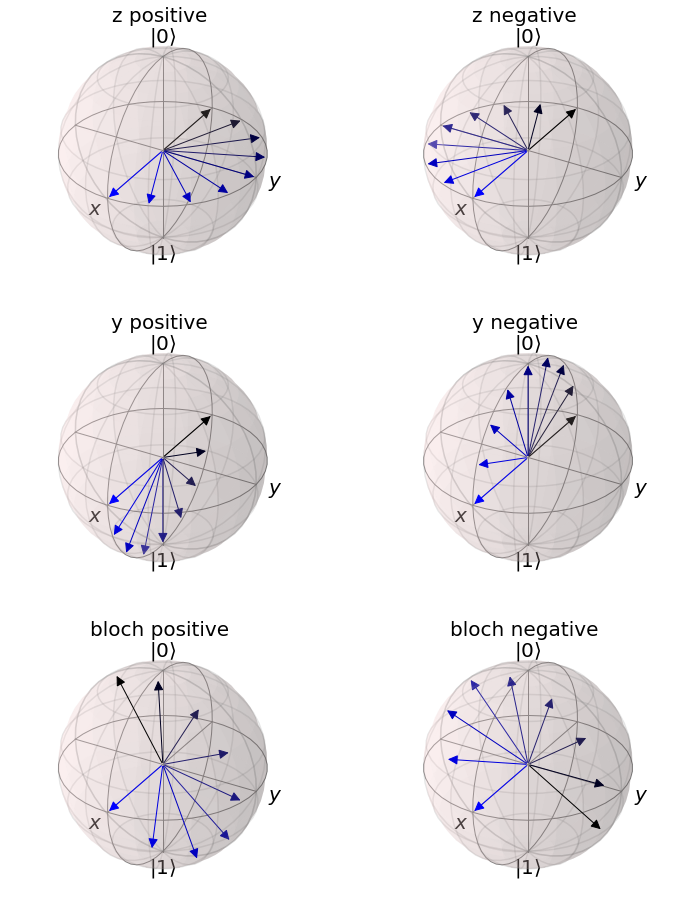

In [30]:
fig, ax = plt.subplots(figsize = [12, 16], nrows=4, ncols=2, clear=True)

#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
[axis.set_axis_off() for axis in ax.ravel()]

#rotation_names = [ "z positive", "z negative","y positive", "y negative", "bloch positive", "bloch negative", "x positive", "x negative",]
#rotations = [[pi/8, 0, 0], [-pi/8, 0, 0], [0, pi/8, 0], [0, -pi/8, 0], [0, pi/8, pi/8], [0, -pi/8, -pi/8], [0, 0, pi/8], [0, 0, -pi/8]]

rotations = [[0, 0, pi/8], [0, 0, -pi/8],[0, pi/8, 0], [0, -pi/8, 0], [0, pi/8, pi/8], [0, -pi/8, -pi/8]]

rotation_names = [ "z positive", "z negative","y positive", "y negative", "bloch positive", "bloch negative"]

start_vec = np.array([1, 0, 0])

norm_factor = np.sqrt((start_vec**2).sum())
start_vec = start_vec/norm_factor

num_iterations = 8


for m, rotation in enumerate(rotations[:]):


    # ploting preparation:
    ax = fig.add_subplot(320+(m+1), axes_class = Axes3D)
    rot_x = rotation[0]
    rot_y = rotation[1]
    rot_z = rotation[2]

    _bloch = Bloch(axes=ax)
    _bloch.vector_color = get_gradient_colors([0, 0, 1], num_iterations)
    _bloch.vector_width = 1

    sv = []
    vec = start_vec
    sv.append(vec)

    # perform rotation
    for i in range(num_iterations):
        vec = np.array(rn_su2_euler(vec, rot_x, rot_y, rot_z), dtype=np.float32)
        sv.append(vec)

    _bloch.add_vectors(sv)
    _bloch.render(title=rotation_names[m])